# Fannie Mae Single-Family Datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re
from typing import Union, List

from sklearn.preprocessing import MinMaxScaler

# Load files

In [4]:
DATA_PATH = '../datasets/FannieMae/'
glossary = pd.read_excel(DATA_PATH+'crt-file-layout-and-glossary_0.xlsx')
glossary = glossary[~glossary.isna().all(axis=1)] # Remove nan rows
glossary_cols =  glossary['Field Name'].loc[~glossary['Field Name'].isnull()].reset_index(drop=True)

In [5]:
def load_fanniemae_sf(path: str, 
                      Y: Union[int, list]=None, 
                      Q: Union[int, str]=None, 
                      cols: List[str]=None, 
                      selected_features: List[str]=None) -> pd.DataFrame:
    # Files to load
    if isinstance(Y, int):
        Y = [Y]  # Convert single year to list
    if isinstance(Q, int):
        Q = [Q]  # Convert single quarter to list
    files = []
    for year in Y:
        if Q == 'all':
            pattern = os.path.join(path, f"{year}Q*.csv")
            files.extend(glob.glob(pattern))
        else:
            for quarter in Q:
                pattern = os.path.join(path, f"{year}Q{quarter}.csv")
                files.extend(glob.glob(pattern))
    print("Files to load:", files)
    df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)

    # Select Features
    if selected_features is None:
        sf_fields = glossary[~glossary['Single-Family (SF) Loan Performance'].isna()]['Field Name'].to_list()
        df = df[sf_fields]
    else:
        df = df[selected_features]
        
    # Format column names
    df.rename(columns={s:'_'.join(s.strip().lower().split()).replace('-', '_') for s in selected_features}, inplace=True)

    # Time features
    df.insert(1, 'time', pd.to_datetime(df['monthly_reporting_period'], format='%m%Y'))
    df.insert(2, 'year', df.time.dt.year)
    df.drop('monthly_reporting_period', axis=1, inplace=True)

    # Rename columns
    df.rename(columns={
        'current_loan_delinquency_status':'delinquency_status',
                }, inplace=True) 
    return df

In [8]:
%%time
df05Q1 = load_fanniemae_sf(DATA_PATH, Y=2005, Q=1, cols=glossary_cols, selected_features=selected_fields)

Files to load: ['../datasets/FannieMae/2005Q1.csv']


/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_64193/4065276026.py:21: DtypeWarning: Columns (40,101,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)


CPU times: user 54.8 s, sys: 34.5 s, total: 1min 29s
Wall time: 1min 45s


In [11]:
df05Q1.head()

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
0,100000102115,2005-03-01,2005,C,4.5,4.5,95000.0,0.0,120,0.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
1,100000102115,2005-04-01,2005,C,4.5,4.5,95000.0,0.0,120,1.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
2,100000102115,2005-05-01,2005,C,4.5,4.5,95000.0,0.0,120,2.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
3,100000102115,2005-06-01,2005,C,4.5,4.5,95000.0,0.0,120,3.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
4,100000102115,2005-07-01,2005,C,4.5,4.5,95000.0,0.0,120,4.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN


## Feature selection

In [7]:
selected_fields=[
'Loan Identifier',
'Monthly Reporting Period',
'Channel',
'Original Interest Rate',
'Current Interest Rate',
'Original UPB',
'Current Actual UPB',
'Original Loan Term',
'Loan Age',
'Remaining Months To Maturity',
'Original Loan to Value Ratio (LTV)',
'Original Combined Loan to Value Ratio (CLTV)',
'Number of Borrowers',
'Debt-To-Income (DTI)',
'Borrower Credit Score at Origination',
'Co-Borrower Credit Score at Origination',
'First Time Home Buyer Indicator',
'Loan Purpose ',
'Property Type',
'Number of Units',
'Occupancy Status',
'Property State',
'Metropolitan Statistical Area (MSA)',
'Zip Code Short',
'Mortgage Insurance Percentage',
'Amortization Type',
'Prepayment Penalty Indicator',
'Interest Only Loan Indicator',
'Interest Only First Principal And Interest Payment Date',
'Months to Amortization',
'Current Loan Delinquency Status',
'Zero Balance Code',
'Zero Balance Effective Date',
'UPB at the Time of Removal',
'Total Principal Current',
'Last Paid Installment Date',
'Foreclosure Date',
'Special Eligibility Program',
'Property Valuation Method ',
'High Balance Loan Indicator ',
'Borrower Assistance Plan',
'Alternative Delinquency Resolution',
'Alternative Delinquency  Resolution Count']

### Notes

- Check features that are present in 'SF Loan Performance: Enhanced format with the October 2020 Release'
- Features 'Origination Date', 'First Payment Date', 'Maturity Date' has to convert to date
- Double check 'Loan Age' for negative values and nan
- Everything related to or after foreclosure is excluded
- Features related to Covid-19: 'Alternative Delinquency Resolution', 'Alternative Delinquency  Resolution Count'

In [475]:
feature = 'Alternative Delinquency  Resolution Count'

print(feature, '\n')
if feature in df_missing.index:
    print(f'Missing values: {df_missing.loc[feature].freq.round(6)*100:.4f}% missing values.')
else:
    print(f'No missing values.')
print(f'Number of unique values: {df[feature].nunique()}')

Alternative Delinquency  Resolution Count 

Missing values: 99.9240% missing values.
Number of unique values: 2


In [476]:
df[feature].sample(10)

1051490   NaN
1271527   NaN
1871826   NaN
3155123   NaN
2787929   NaN
3146109   NaN
3171525   NaN
1737404   NaN
1254018   NaN
3835307   NaN
Name: Alternative Delinquency  Resolution Count, dtype: float64

In [481]:
df[feature].nunique()

2

In [474]:
df[feature].unique()

array(['7', 'P', 7, 'C', 'D'], dtype=object)

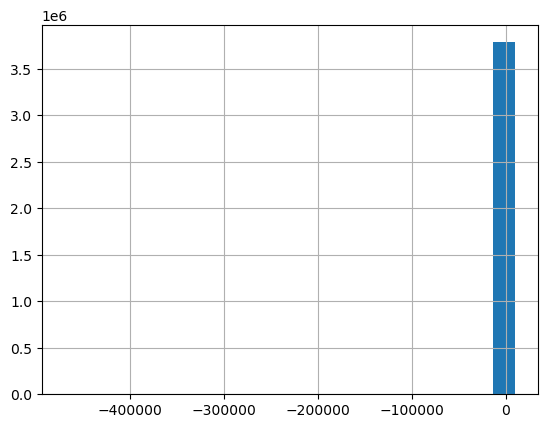

In [450]:
fig, ax = plt.subplots()
df[feature].loc[df[feature] < 1e4].hist(bins=20, ax=ax)
ax.set_xscale('linear')

<Axes: xlabel='Alternative Delinquency Resolution'>

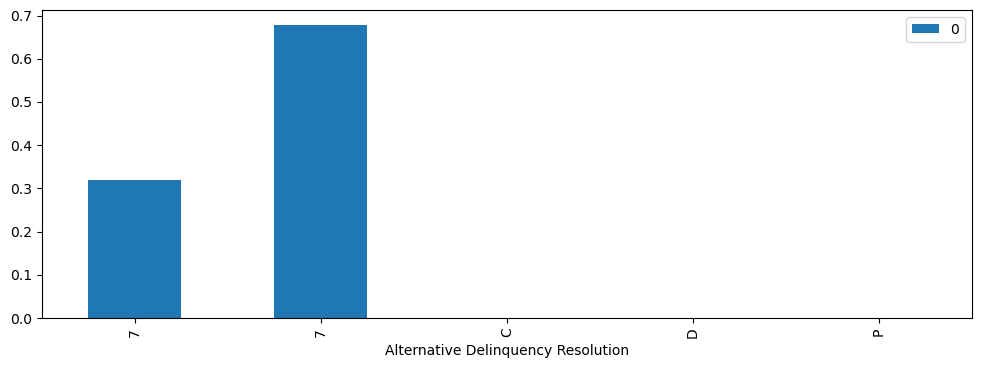

In [473]:
fig, ax = plt.subplots(figsize=(12, 4))
(df.groupby(feature).size().to_frame()/df.shape[0]).plot(kind='bar', ax=ax)

## Missing values

In [62]:
def missing(df):
    missing_values = df.isna().sum()/len(df)
    missing_values = pd.DataFrame(missing_values.loc[missing_values != 0], 
                                  columns=['freq'])#.reset_index(names='Field Name')#.sort_values(by='freq')
    return missing_values

def plot_missing(df_missing, ax=None):
    df_missing.plot(kind='barh', ax=ax)

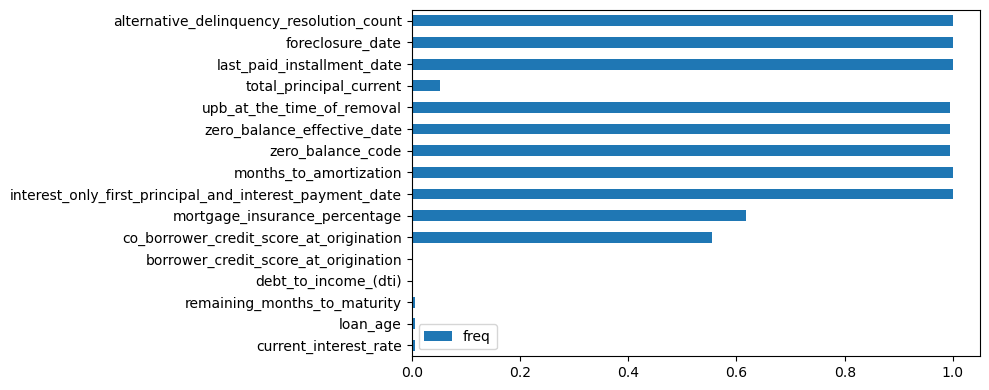

In [572]:
fig, ax = plt.subplots(figsize=(10, 4))

df_missing = missing(df)
plot_missing(df_missing, ax=ax)

plt.tight_layout()
plt.show()

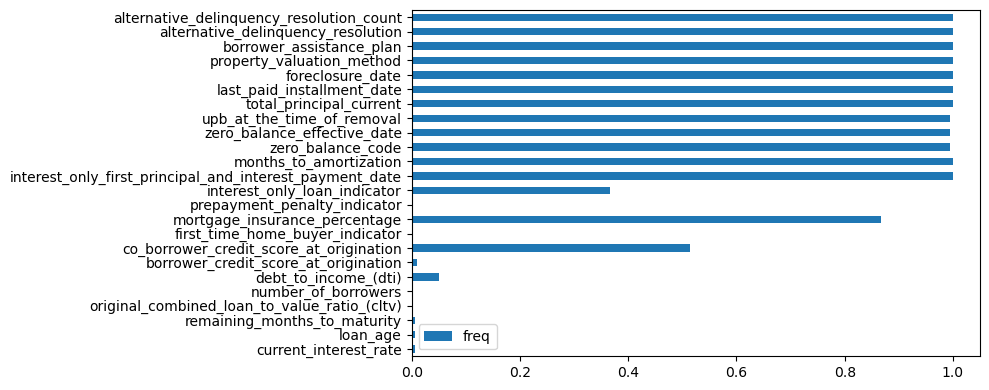

In [63]:
fig, ax = plt.subplots(figsize=(10, 4))

df_missing = missing(df2005_123)
plot_missing(df_missing, ax=ax)

plt.tight_layout()
plt.show()

## Agreggate years

In [588]:
%%time
df05Q1 = load_fanniemae_sf(path, Y=2005, Q=1, cols=cols, selected_features=select_fields)

Files to load: ['../datasets/FannieMae/2005Q1.csv']


/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_21885/1685962122.py:21: DtypeWarning: Columns (40,101,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)


CPU times: user 54.4 s, sys: 32.6 s, total: 1min 27s
Wall time: 1min 41s


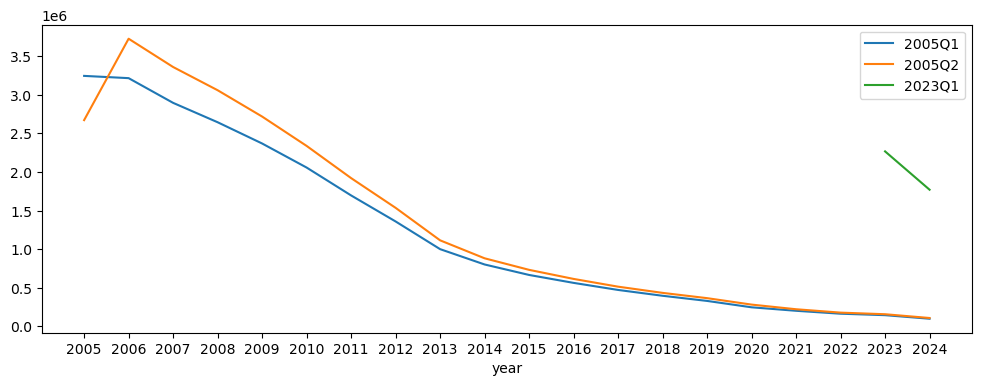

In [785]:
fig, ax = plt.subplots(figsize=(12, 4))

df05.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2005Q1')
df05Q2.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2005Q2')
df23Q1.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2023Q1')

ax.legend()
ax.set_xticks(np.arange(2005, 2025))

plt.show()

### Split years


In [33]:
AGG_PATH = DATA_PATH+'aggregate_years/'

In [741]:
df05Q2['acquisition'] = '2005Q2'

In [771]:
pd.DataFrame(df2005_2.acquisition.unique(), columns=['acquisition'])

,acquisition
0,2005Q1
1,2005Q2


In [70]:
def split_years(save_path: str, df: pd.DataFrame):
    ''' Split years and save each year in a separate csv file.'''
    for y in df.year.unique():
        print(f'Saving {y}')
        df_year = df.loc[df.year == y]  # Filter year
        # Save path
        file_path = f'{save_path}agg_{y}.csv'
        meta_path = f'{save_path}agg_{y}_meta.csv'
        
        # Check if file exists before reading
        if os.path.exists(file_path):
            df_agg = pd.read_csv(file_path)  # Load existing data
            df_agg = pd.concat([df_agg, df_year], ignore_index=True)  # Append new data
        else:
            df_agg = df_year  # Start a new DataFrame if the file doesn’t exist

        # Save the updated DataFrame
        df_agg.sort_values(by=['time', 'loan_identifier'])
        df_agg.to_csv(file_path, index=False)
        # Meta data
        df_meta = pd.DataFrame(df_agg['acquisition'].unique(), columns=['acquisition'])
        df_meta.to_csv(meta_path, index=False)


In [42]:
def aggregate_fanniemae(input_path: str, 
                        output_path: str, 
                        years: List[int], 
                        quarters: List[int], 
                        cols: pd.Series, 
                        selected_features: List[str]) -> None:
    for y in years:
        if quarters == 'all':
            quarters = [1, 2, 3, 4]
        for q in quarters:
            df = load_fanniemae_sf(input_path, Y=y, Q=q, cols=cols, selected_features=selected_features)
            acq = f'{y}Q{q}'
            df['acquisition'] = acq
            print(f'Splitting {acq}')
            split_years(output_path, df)

In [54]:
%%time
YEAR_LIST = [2005]
QUARTER_LIST = [3]
aggregate_fanniemae(DATA_PATH, AGG_PATH, YEAR_LIST, QUARTER_LIST, cols=glossary_cols, selected_features=selected_fields)

Files to load: ['../datasets/FannieMae/2005Q3.csv']


/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_64193/4065276026.py:21: DtypeWarning: Columns (40,101,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)


Splitting 2005Q3
Saving 2005
Saving 2006
Saving 2007
Saving 2008
Saving 2009
Saving 2010
Saving 2011
Saving 2012
Saving 2013
Saving 2014
Saving 2015
Saving 2016
Saving 2017
Saving 2018
Saving 2019
Saving 2020
Saving 2021
Saving 2022
Saving 2023
Saving 2024
CPU times: user 16min 26s, sys: 2min 9s, total: 18min 36s
Wall time: 19min 19s


In [41]:
pd.read_csv(f'{AGG_PATH}agg_2005_meta.csv')

,Unnamed: 0,acquisition
0,0,2005Q1
1,1,2005Q2


In [56]:
pd.read_csv(f'{AGG_PATH}agg_2023_meta.csv')

,acquisition
0,2005Q1
1,2005Q2
2,2005Q3


In [45]:
%%time
df2005_12 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 6.24 s, sys: 1.24 s, total: 7.49 s
Wall time: 7.51 s


In [57]:
%%time
df2005_123 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 8.79 s, sys: 2 s, total: 10.8 s
Wall time: 11 s


In [58]:
df2005_123.head()

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count,acquisition
0,100000102115,2005-03-01,2005,C,4.5,4.5,95000.0,0.0,120,0.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
1,100000102115,2005-04-01,2005,C,4.5,4.5,95000.0,0.0,120,1.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
2,100000102115,2005-05-01,2005,C,4.5,4.5,95000.0,0.0,120,2.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
3,100000102115,2005-06-01,2005,C,4.5,4.5,95000.0,0.0,120,3.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
4,100000102115,2005-07-01,2005,C,4.5,4.5,95000.0,0.0,120,4.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1


In [68]:
%%time
df2005_123.sort_values(by=['time', 'loan_identifier']).head()

CPU times: user 1.4 s, sys: 369 ms, total: 1.77 s
Wall time: 1.86 s


,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count,acquisition
10,100001329224,2005-01-01,2005,B,5.875,5.875,141000.0,0.0,360,0.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
25,100004945019,2005-01-01,2005,R,5.875,5.875,104000.0,0.0,360,0.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
47,100014052527,2005-01-01,2005,C,5.625,5.625,60000.0,0.0,240,0.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
59,100014432938,2005-01-01,2005,R,6.375,6.375,54000.0,0.0,360,1.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
101,100026722670,2005-01-01,2005,R,5.500,5.500,134000.0,0.0,360,0.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1


In [69]:
%%time
df2005_123.sort_values(by=['time', 'loan_identifier']).tail()

CPU times: user 1.44 s, sys: 348 ms, total: 1.78 s
Wall time: 1.87 s


,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count,acquisition
5917732,999991120469,2005-12-01 00:00:00,2005,C,5.625,5.625,76000.0,74618.76,360,10.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q2
8086680,999991984426,2005-12-01 00:00:00,2005,C,4.990,4.990,257000.0,0.00,360,5.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3
8086684,999995025673,2005-12-01 00:00:00,2005,C,5.500,5.500,242000.0,0.00,360,3.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3
8086690,999995753815,2005-12-01 00:00:00,2005,R,5.750,5.750,175000.0,0.00,360,6.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3
8086695,999998146234,2005-12-01 00:00:00,2005,R,4.750,4.750,56000.0,0.00,360,4.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3


In [59]:
df2005_123.tail()

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count,acquisition
8086691,999998146234,2005-08-01 00:00:00,2005,R,4.75,4.75,56000.0,0.0,360,0.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3
8086692,999998146234,2005-09-01 00:00:00,2005,R,4.75,4.75,56000.0,0.0,360,1.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3
8086693,999998146234,2005-10-01 00:00:00,2005,R,4.75,4.75,56000.0,0.0,360,2.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3
8086694,999998146234,2005-11-01 00:00:00,2005,R,4.75,4.75,56000.0,0.0,360,3.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3
8086695,999998146234,2005-12-01 00:00:00,2005,R,4.75,4.75,56000.0,0.0,360,4.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q3


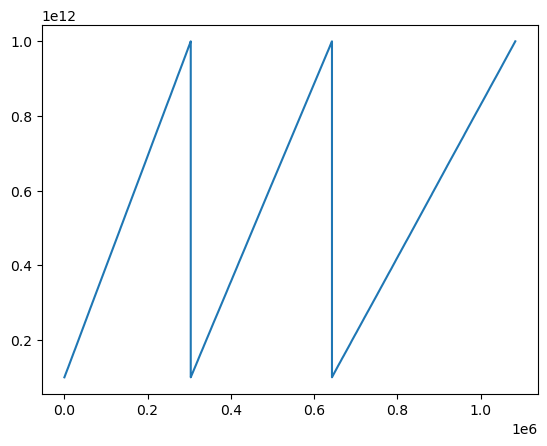

In [61]:
plt.plot(df2005_123.loan_identifier.unique())

<Axes: >

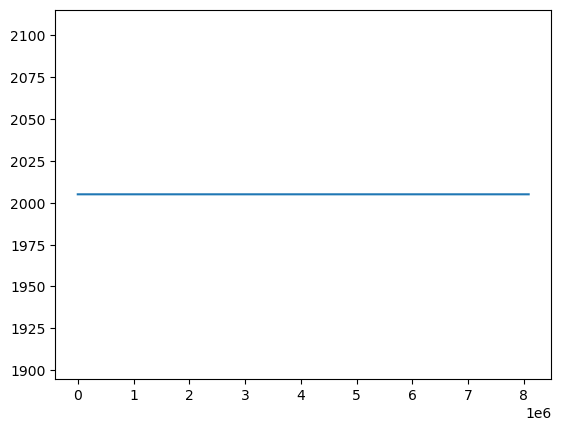

In [65]:
df2005_123.year.plot()

In [ ]:
%%time
df2005_123.sort_values(by=)

In [51]:
%%time

df2006_12 = pd.read_csv(f'{AGG_PATH}agg_2006.csv')

CPU times: user 7.48 s, sys: 1.56 s, total: 9.04 s
Wall time: 9.13 s


In [46]:
df2005_12.delinquency_status.unique()

array(['00', 'XX', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10', '11'], dtype=object)

In [47]:
df2005_12

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count,acquisition
0,100000102115,2005-03-01,2005,C,4.500,4.500,95000.0,0.00,120,0.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
1,100000102115,2005-04-01,2005,C,4.500,4.500,95000.0,0.00,120,1.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
2,100000102115,2005-05-01,2005,C,4.500,4.500,95000.0,0.00,120,2.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
3,100000102115,2005-06-01,2005,C,4.500,4.500,95000.0,0.00,120,3.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
4,100000102115,2005-07-01,2005,C,4.500,4.500,95000.0,0.00,120,4.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5917728,999991120469,2005-08-01 00:00:00,2005,C,5.625,5.625,76000.0,0.00,360,6.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q2
5917729,999991120469,2005-09-01 00:00:00,2005,C,5.625,5.625,76000.0,0.00,360,7.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q2
5917730,999991120469,2005-10-01 00:00:00,2005,C,5.625,5.625,76000.0,74792.99,360,8.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q2
5917731,999991120469,2005-11-01 00:00:00,2005,C,5.625,5.625,76000.0,74706.08,360,9.0,...,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN,2005Q2


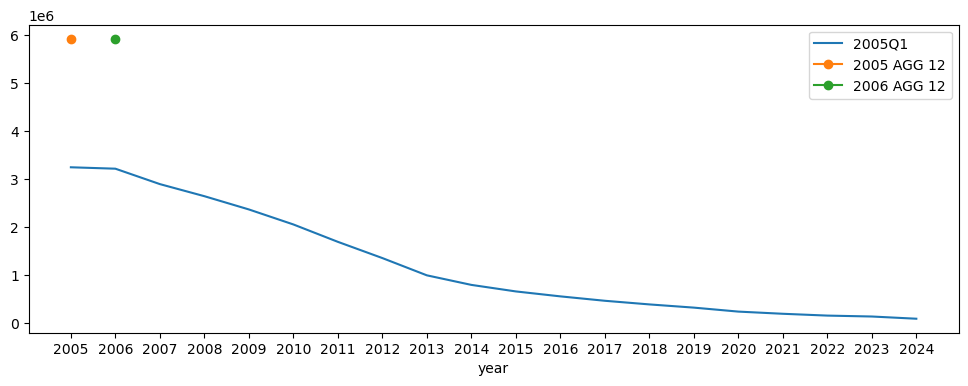

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))

df05Q1.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2005Q1')
# df23.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2023Q1')
ax.plot(2005, len(df2005_12), marker='o', label='2005 AGG 12')
ax.plot(2006, len(df2005_12), marker='o', label='2006 AGG 12')

ax.legend()
ax.set_xticks(np.arange(2005, 2025))

plt.show()

## Definition of Default

- Two variable are used to define default: 'Zero Balance Code' and the delinquency status ('Current Loan Delinquency Status')
- Zero Balance Codes that are a default event: 3, 6, 9
- Delinquency status can be 3 months (> 90 days) or 6 months (> 180 days), etc.

### Delinquency Status

In [634]:
df05.zero_balance_code.value_counts(dropna=False)

zero_balance_code
NaN     24266914
1.0       277494
9.0         8866
16.0        2246
3.0         2023
2.0         1199
15.0         858
6.0          570
Name: count, dtype: int64

In [637]:
df05.delinquency_status.value_counts(dropna=False)

delinquency_status
00    23122655
01      511383
XX      282663
02      150212
03       71131
        ...   
94          96
95          89
97          82
96          81
98          73
Name: count, Length: 101, dtype: int64

In [640]:
dlq_zb = df05.groupby(['delinquency_status', 'zero_balance_code']).size().to_frame().rename(columns={0:'Counts'})

In [673]:
dlq_zb

Counts
delinquency_status zero_balance_code        
00                 1.0                  9292
                   3.0                     1
                   6.0                     1
                   15.0                  181
                   16.0                 1053
...                                      ...
XX                 3.0                  2010
                   6.0                   569
                   9.0                  8804
                   15.0                  677
                   16.0                 1193

[95 rows x 1 columns]

In [680]:
dlq_zb.xs('XX', level='delinquency_status', drop_level=False)

Counts
delinquency_status zero_balance_code        
XX                 1.0                268202
                   2.0                  1139
                   3.0                  2010
                   6.0                   569
                   9.0                  8804
                   15.0                  677
                   16.0                 1193

In [705]:
%%time
df05.delinquency_status = df05.delinquency_status.replace('XX', -np.inf)
df05.delinquency_status = df05.delinquency_status.astype(float)

CPU times: user 2.05 s, sys: 112 ms, total: 2.16 s
Wall time: 2.16 s


In [707]:
%%time
df.delinquency_status = df.delinquency_status.replace('XX', -np.inf)
df.delinquency_status = df.delinquency_status.astype(float)

CPU times: user 2.37 s, sys: 205 ms, total: 2.58 s
Wall time: 2.59 s


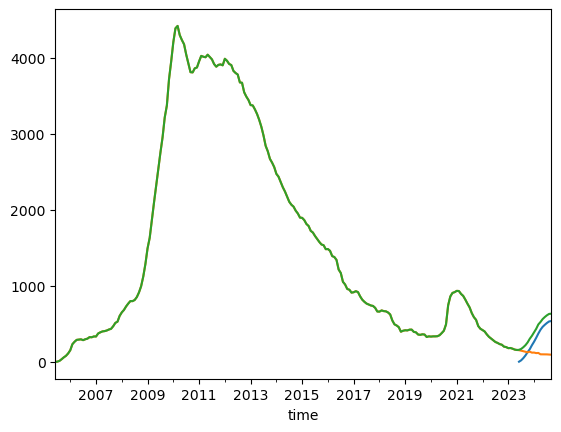

In [708]:
fig, ax = plt.subplots()

df23.loc[df23.delinquency_status >= 6].groupby('time').size().plot(ax=ax)
df05.loc[df05.delinquency_status >= 6].groupby('time').size().plot(ax=ax)
df.loc[df.delinquency_status >= 6].groupby('time').size().plot(ax=ax)

plt.show()

TypeError: '>=' not supported between instances of 'str' and 'int'

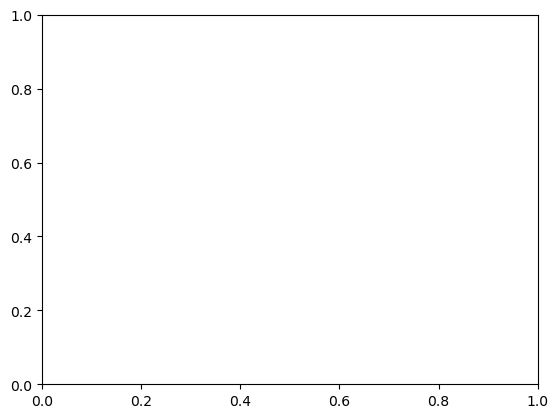

In [53]:
fig, ax = plt.subplots()

# df23.loc[df23.delinquency_status >= 3].groupby('time').size().plot(ax=ax)
df05Q1.loc[df05Q1.delinquency_status >= 3].groupby('time').size().plot(ax=ax)
# df.loc[df.delinquency_status >= 3].groupby('time').size().plot(ax=ax)

plt.show()

### Zero Balance Code

<Axes: >

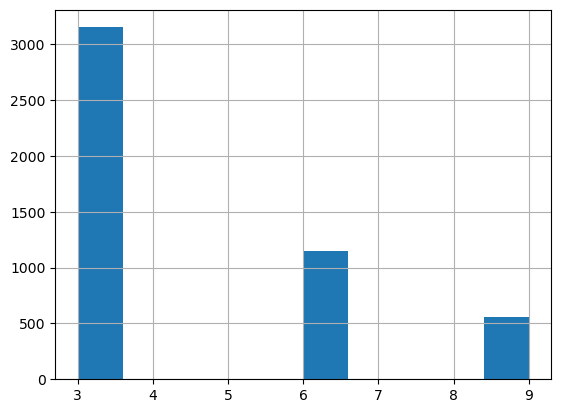

In [584]:
df.loc[df.delinquency_status.isin([3, 6, 9])].delinquency_status.hist()

In [575]:
df.current_loan_delinquency_status

0          0
1          0
2          0
3          0
4          0
          ..
4037218    0
4037219    0
4037220    0
4037221    0
4037222    0
Name: current_loan_delinquency_status, Length: 4037223, dtype: int64

In [32]:
def default(df):
    
    return df.loc[(df.zb.isin([3, 6, 9]))|(df.dlq >= 3)].groupby('time').size()

In [7]:
%%time
df24q1_def = default_df(df24q1)

KeyError: "['Current Loan Delinquency Status', 'Zero Balance Code'] not in index"

<Axes: xlabel='time'>

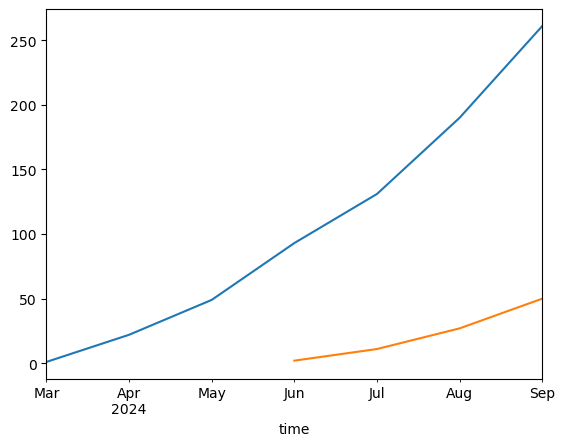

In [13]:
fig, ax = plt.subplots()

df24q1.loc[df24q1.dlq >= 3].groupby('time').size().plot(ax=ax)
df24q1.loc[df24q1.dlq >= 6].groupby('time').size().plot(ax=ax)

In [19]:
pd.concat([df24q1.loc[df24q1.dlq >= 3].groupby('time').size(),
           df24q1.loc[df24q1.dlq >= 6].groupby('time').size()], axis=1).fillna(0)

,0,1
time,,
2024-03-01,1,0.0
2024-04-01,22,0.0
2024-05-01,49,0.0
2024-06-01,93,2.0
2024-07-01,131,11.0
2024-08-01,190,27.0
2024-09-01,261,50.0


In [37]:
df24q1.loc[df24q1.zb.isin([3, 6, 9])]

,Reference Pool ID,id,Monthly Reporting Period,time,year,Channel,Seller Name,Servicer Name,Master Servicer,Original Interest Rate,...,ARM Plan Number,Borrower Assistance Plan,High Loan to Value (HLTV) Refinance Option Indicator,Deal Name,Repurchase Make Whole Proceeds Flag,Alternative Delinquency Resolution,Alternative Delinquency Resolution Count,Total Deferral Amount,Payment Deferral Modification Event Indicator,Interest Bearing UPB
2092,NaN,137581683,82024,2024-08-01,2024,C,Other,NaN,NaN,7.500,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
3680,NaN,137581862,22024,2024-02-01,2024,R,NewRez LLC,NaN,NaN,8.125,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
17071,NaN,137583380,72024,2024-07-01,2024,R,Other,NaN,NaN,6.875,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
24607,NaN,137584231,82024,2024-08-01,2024,R,"Wells Fargo Bank, N.A.",NaN,NaN,7.625,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
33590,NaN,137585250,52024,2024-05-01,2024,R,"CrossCountry Mortgage, LLC",NaN,NaN,6.250,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461656,NaN,138000322,82024,2024-08-01,2024,R,Other,NaN,NaN,6.600,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
1465009,NaN,138000806,42024,2024-04-01,2024,C,Other,NaN,NaN,6.500,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
1465223,NaN,138000838,62024,2024-06-01,2024,B,"Rocket Mortgage, LLC",NaN,NaN,6.990,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN
1481762,NaN,138003225,42024,2024-04-01,2024,R,Other,NaN,NaN,6.375,...,NaN,7,N,NaN,Y,7,NaN,NaN,7,NaN


In [19]:
pd.concat([df24q1.loc[df24q1.dlq >= 3].groupby('time').size(),
           df24q1.loc[df24q1.dlq >= 6].groupby('time').size()], axis=1).fillna(0)

,0,1
time,,
2024-03-01,1,0.0
2024-04-01,22,0.0
2024-05-01,49,0.0
2024-06-01,93,2.0
2024-07-01,131,11.0
2024-08-01,190,27.0
2024-09-01,261,50.0


In [33]:
default_df(df24q1)

time
2024-02-01      1
2024-03-01      3
2024-04-01     31
2024-05-01     53
2024-06-01    109
2024-07-01    153
2024-08-01    222
2024-09-01    320
dtype: int64

In [11]:
df_def.zb.value_counts()

zb
1.0     241245
9.0       2685
6.0        980
2.0        494
16.0       343
3.0        154
15.0        88
Name: count, dtype: int64

In [19]:
df2012Q1_def = df2012Q1[['time', 'Current Loan Delinquency Status', 'Zero Balance Code']].rename(
    columns={'Current Loan Delinquency Status':'dlq', 'Zero Balance Code':'zb'})
df2012Q1_def.loc[df2012Q1_def.zb.isin([3, 6, 9])]

,time,dlq,zb
54630,2017-08-01,XX,9.0
108104,2012-07-01,XX,6.0
142756,2017-02-01,XX,9.0
252834,2013-01-01,XX,9.0
265332,2017-07-01,XX,9.0
...,...,...,...
48536844,2014-11-01,XX,9.0
48578985,2017-05-01,XX,9.0
48591761,2017-03-01,XX,9.0
48609564,2013-05-01,XX,6.0


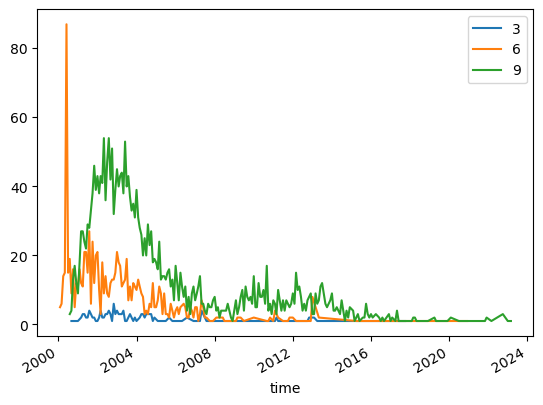

In [12]:
fig, ax  = plt.subplots()

for z in [3, 6, 9]:
    df_def.loc[df_def.zb == z].groupby('time').size().plot(ax=ax, label=str(z))

ax.legend()

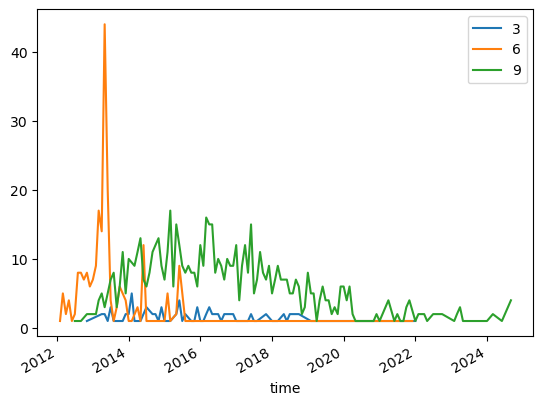

In [21]:
fig, ax  = plt.subplots()

for z in [3, 6, 9]:
    df2012Q1_def.loc[df2012Q1_def.zb == z].groupby('time').size().plot(ax=ax, label=str(z))

ax.legend()

In [20]:
def plot_def(df_def, startY=None, endY=None, zb_codes=[], df_label=None, ax=None):
    
    for z in zb_codes:
        df_date = df_def.loc[(df_def.time.dt.year >= startY)&(df_def.time.dt.year <= endY)]
        df_date.loc[df_date.zb == z].groupby('time').size().plot(ax=ax, label=str(z)+' '+df_label)
    
    ax.legend()

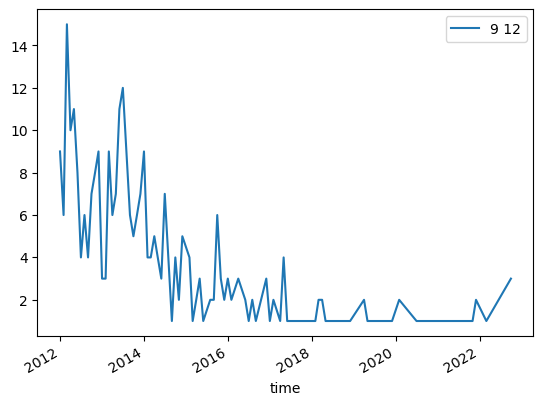

In [21]:
fig, ax = plt.subplots()

plot_def(df00q1_def, startY=2012, endY=2022, zb_codes=[9], df_label='12', ax=ax)

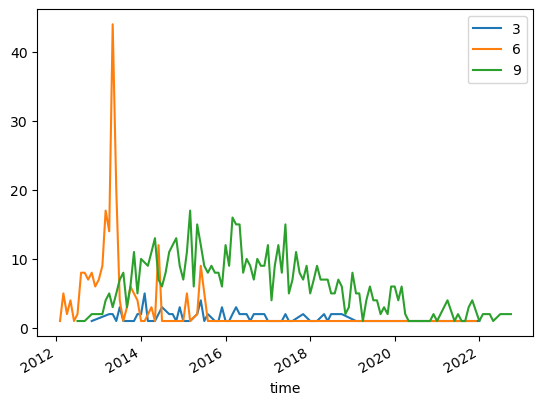

In [24]:
fig, ax  = plt.subplots()

for z in [3, 6, 9]:
    df_date = df2012Q1_def.loc[(df2012Q1_def.time.dt.year >= 2012)&(df2012Q1_def.time.dt.year <= 2022)]
    df_date.loc[df_date.zb == z].groupby('time').size().plot(ax=ax, label=str(z))

ax.legend()

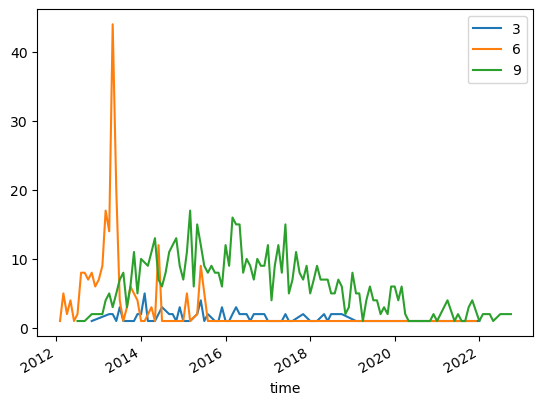

In [24]:
fig, ax  = plt.subplots()

for z in [3, 6, 9]:
    df_date = df2012Q1_def.loc[(df2012Q1_def.time.dt.year >= 2012)&(df2012Q1_def.time.dt.year <= 2022)]
    df_date.loc[df_date.zb == z].groupby('time').size().plot(ax=ax, label=str(z))

ax.legend()

## Macro

<Axes: xlabel='time'>

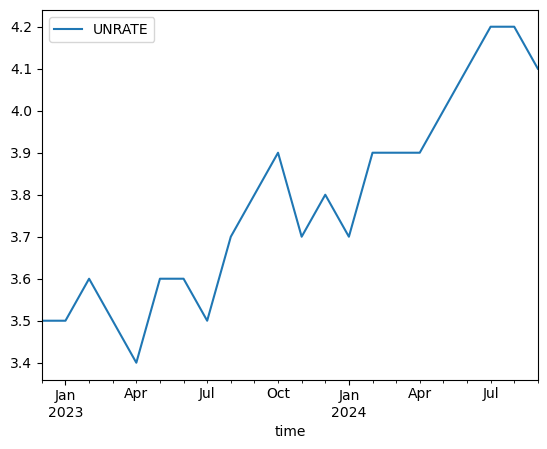

In [198]:
pd.concat([df_def.loc[df_def.dlq >= 3].groupby('time', as_index=False).size().set_index('time'), 
           uer.set_index('time')], axis=1).dropna().plot(y='UNRATE')



In [251]:
def load_fred(file_name, path):
    df = pd.read_csv(path+file_name)
    df['time'] = pd.to_datetime(df.observation_date)
    df.drop('observation_date', axis=1, inplace=True)
    return df

In [304]:
# Unemployment rate
uer = pd.read_csv(path+'macro/UNRATE.csv')
uer['time'] = pd.to_datetime(uer.observation_date)
uer.drop('observation_date', axis=1, inplace=True)

In [292]:
# House Price Index
# S&P CoreLogic Case-Shiller U.S. National Home Price Index (CSUSHPISA)
hpi = pd.read_csv(path+'macro/CSUSHPISA.csv')
hpi['time'] = pd.to_datetime(hpi.observation_date)
hpi.drop('observation_date', axis=1, inplace=True)

In [293]:
# Interest Rates
ir30 = load_fred('MORTGAGE30US.csv', path+'macro/')
ir15 = load_fred('MORTGAGE15US.csv', path+'macro/')

In [320]:
# GDP
gdp = load_fred('GDP.csv', path+'macro/')

In [321]:
gdp=pd.DataFrame(pd.concat([df_def.loc[df_def.dlq >= 3].groupby('time', as_index=False).size()
                      .set_index('time').rename(columns={'size':'default'}), 
                      gdp.set_index('time')
                     ], axis=1).ffill().dropna()['GDP']).reset_index()
gdp

,time,GDP
0,2022-12-01,26734.277
1,2023-01-01,27164.359
2,2023-02-01,27164.359
3,2023-03-01,27164.359
4,2023-04-01,27453.815
5,2023-05-01,27453.815
6,2023-06-01,27453.815
7,2023-07-01,27967.697
8,2023-08-01,27967.697
9,2023-09-01,27967.697


In [324]:
df_macro = pd.concat([df_def.loc[df_def.dlq >= 3].groupby('time', as_index=False).size()
                      .set_index('time').rename(columns={'size':'default'}), 
                      uer.set_index('time').rename(columns={'UNRATE':'uer'}),
                      hpi.set_index('time').rename(columns={'CSUSHPISA':'hpi'}),
                      ir30.set_index('time').rename(columns={'MORTGAGE30US':'ir30'}),
                      ir15.set_index('time').rename(columns={'MORTGAGE15US':'ir15'}),
                      ir15.set_index('time').rename(columns={'MORTGAGE15US':'ir15'}),
                      gdp.set_index('time')
                     ], axis=1).dropna()

In [325]:
df_macro

,default,uer,hpi,ir30,ir15,ir15,GDP
time,,,,,,,
2022-12-01,8.0,3.5,297.689,6.36,5.67,5.67,26734.277
2023-01-01,72.0,3.5,297.517,6.27,5.43,5.43,27164.359
2023-02-01,176.0,3.6,298.037,6.26,5.42,5.42,27164.359
2023-03-01,248.0,3.5,298.972,6.54,5.80,5.80,27164.359
2023-04-01,352.0,3.4,300.281,6.34,5.66,5.66,27453.815
2023-05-01,428.0,3.6,302.262,6.43,5.81,5.81,27453.815
2023-06-01,530.0,3.6,304.281,6.71,6.09,6.09,27453.815
2023-07-01,623.0,3.5,306.476,6.84,6.18,6.18,27967.697
2023-08-01,741.0,3.7,309.182,7.07,6.43,6.43,27967.697


In [250]:
df_macro.index

DatetimeIndex(['2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='time', freq='MS')

In [326]:
# macro_vars = ['hpi_time', 'gdp_time', 'uer_time']
# df_macro = df.groupby('time')[macro_vars].first()
# df_macro.head(3)

scaler = MinMaxScaler()

# df_macro = pd.concat([default, mean_ir, df_macro], axis=1)
scaler.fit(df_macro)
df_macro_scaled = pd.DataFrame(scaler.fit_transform(df_macro), columns=df_macro.columns)
df_macro_scaled.index = df_macro.index

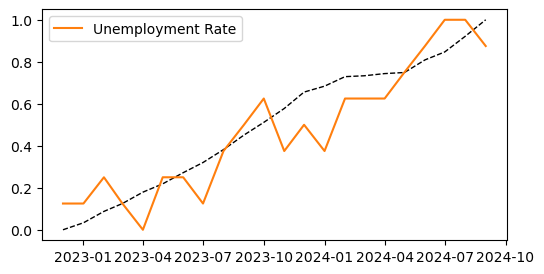

In [225]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))

# Variables
x = df_macro_scaled.index
default = df_macro_scaled.default
# gdp = df_macro_scaled.gdp_time
# mean_ir = df_macro_scaled.mean_ir
hpi = df_macro_scaled.hpi
uer = df_macro_scaled.uer

# # GDP
# ax[0].plot(x, default, label='Default', c='k', ls='--', lw=1)
# ax[0].plot(x, gdp, label='GDP')
# ax[0].legend()

# Unemployment Rate
ax.plot(x, default, label=None, c='k', ls='--', lw=1)
ax.plot(x, uer, label='Unemployment Rate', c='C1')
ax.legend()

# # House Price Index
# ax[2].plot(x, default, label=None, c='k', ls='--', lw=1)
# ax[2].plot(x, hpi, label='HPI', c='C2')
# ax[2].legend()

# # Mean IR
# ax[3].plot(x, default, label=None, c='k', ls='--', lw=1)
# ax[3].plot(x, mean_ir, label='Mean IR', c='C3')
# ax[3].legend()
# ax[3].set_xlabel('Time stamp')

plt.show()

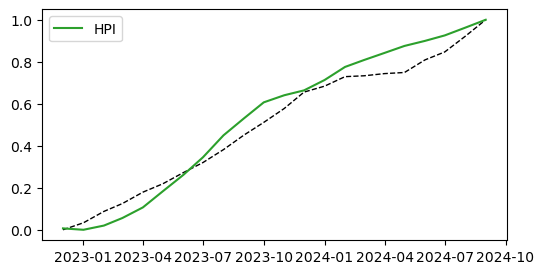

In [246]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))

# Variables
x = df_macro_scaled.index
default = df_macro_scaled.default
# gdp = df_macro_scaled.gdp_time
# mean_ir = df_macro_scaled.mean_ir
hpi = df_macro_scaled.hpi
# uer = df_macro_scaled.uer

# # GDP
# ax[0].plot(x, default, label='Default', c='k', ls='--', lw=1)
# ax[0].plot(x, gdp, label='GDP')
# ax[0].legend()

# Unemployment Rate
# ax.plot(x, default, label=None, c='k', ls='--', lw=1)
# ax.plot(x, uer, label='Unemployment Rate', c='C1')
# ax.legend()

# # House Price Index
ax.plot(x, default, label=None, c='k', ls='--', lw=1)
ax.plot(x, hpi, label='HPI', c='C2')
ax.legend()

# # Mean IR
# ax[3].plot(x, default, label=None, c='k', ls='--', lw=1)
# ax[3].plot(x, mean_ir, label='Mean IR', c='C3')
# ax[3].legend()
# ax[3].set_xlabel('Time stamp')

plt.show()

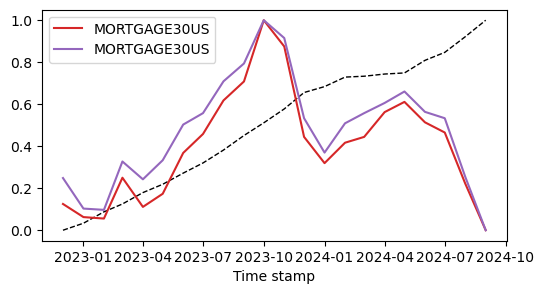

In [288]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))

# Variables
x = df_macro_scaled.index
default = df_macro_scaled.default
# gdp = df_macro_scaled.gdp_time
ir30 = df_macro_scaled.ir30
ir15 = df_macro_scaled.ir15
# hpi = df_macro_scaled.hpi
# uer = df_macro_scaled.uer

# # GDP
# ax[0].plot(x, default, label='Default', c='k', ls='--', lw=1)
# ax[0].plot(x, gdp, label='GDP')
# ax[0].legend()

# Unemployment Rate
# ax.plot(x, default, label=None, c='k', ls='--', lw=1)
# ax.plot(x, uer, label='Unemployment Rate', c='C1')
# ax.legend()

# # House Price Index
# ax.plot(x, default, label=None, c='k', ls='--', lw=1)
# ax.plot(x, hpi, label='HPI', c='C2')
# ax.legend()

# IR
ax.plot(x, default, label=None, c='k', ls='--', lw=1)
ax.plot(x, ir30, label='MORTGAGE30US', c='C3')
ax.plot(x, ir15, label='MORTGAGE30US', c='C4')
ax.legend()
ax.set_xlabel('Time stamp')

plt.show()

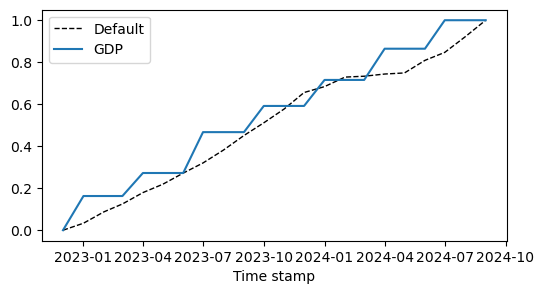

In [327]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))

# Variables
x = df_macro_scaled.index
default = df_macro_scaled.default
gdp = df_macro_scaled.GDP
# ir30 = df_macro_scaled.ir30
# ir15 = df_macro_scaled.ir15
# hpi = df_macro_scaled.hpi
# uer = df_macro_scaled.uer

# GDP
ax.plot(x, default, label='Default', c='k', ls='--', lw=1)
ax.plot(x, gdp, label='GDP')
ax.legend()

# Unemployment Rate
# ax.plot(x, default, label=None, c='k', ls='--', lw=1)
# ax.plot(x, uer, label='Unemployment Rate', c='C1')
# ax.legend()

# # House Price Index
# ax.plot(x, default, label=None, c='k', ls='--', lw=1)
# ax.plot(x, hpi, label='HPI', c='C2')
# ax.legend()

# # IR
# ax.plot(x, default, label=None, c='k', ls='--', lw=1)
# ax.plot(x, ir30, label='MORTGAGE30US', c='C3')
# ax.plot(x, ir15, label='MORTGAGE30US', c='C4')
# ax.legend()
ax.set_xlabel('Time stamp')

plt.show()

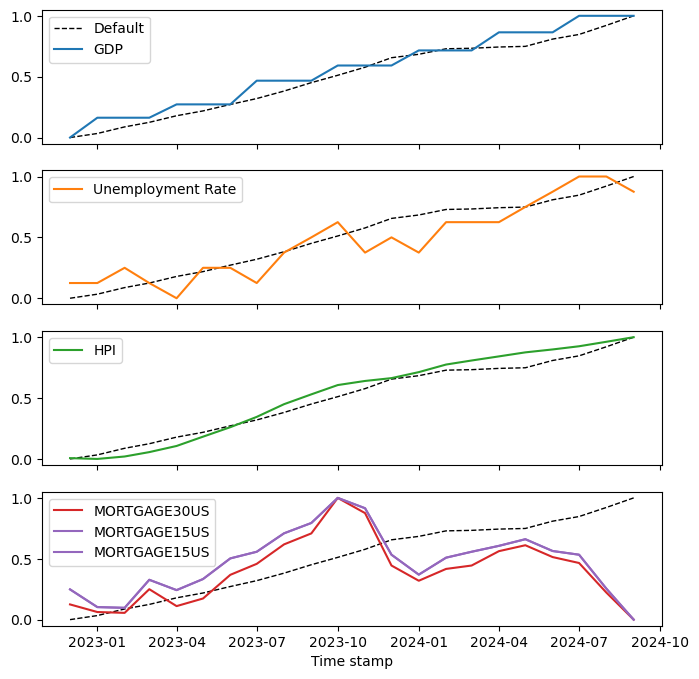

In [328]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 8))

# Variables
x = df_macro_scaled.index
default = df_macro_scaled.default
gdp = df_macro_scaled.GDP
ir15 = df_macro_scaled.ir15
ir30 = df_macro_scaled.ir30
hpi = df_macro_scaled.hpi
uer = df_macro_scaled.uer

# GDP
ax[0].plot(x, default, label='Default', c='k', ls='--', lw=1)
ax[0].plot(x, gdp, label='GDP')
ax[0].legend()

# Unemployment Rate
ax[1].plot(x, default, label=None, c='k', ls='--', lw=1)
ax[1].plot(x, uer, label='Unemployment Rate', c='C1')
ax[1].legend()

# House Price Index
ax[2].plot(x, default, label=None, c='k', ls='--', lw=1)
ax[2].plot(x, hpi, label='HPI', c='C2')
ax[2].legend()

# IR
ax[3].plot(x, default, label=None, c='k', ls='--', lw=1)
ax[3].plot(x, ir30, label='MORTGAGE30US', c='C3')
ax[3].plot(x, ir15, label='MORTGAGE15US', c='C4')
ax[3].legend()
ax[3].set_xlabel('Time stamp')

plt.show()

Features:

- Credit score
- Income
- Demographics/Geography (aggregate features)


Macroeconomics

- GDP
- Unemployment rate
- Interest rates
- 